170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.3572 - loss: 1.7496 - val_accuracy: 0.5471 - val_loss: 1.2559
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - accuracy: 0.5723 - loss: 1.2174 - val_accuracy: 0.5904 - val_loss: 1.1672
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.6363 - loss: 1.0402 - val_accuracy: 0.6364 - val_loss: 1.0223
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.6733 - loss: 0.9285 - val_accuracy: 0.6615 - val_loss: 0.9694
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.6983 - loss: 0.8551 - val_accuracy: 0.6835 - val_loss: 0.9180
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6866 - loss: 0.9084
Accuracy on clean test set: 0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predictions on clean images: [3 8 1 0 4 6 1 4 3 1]
Predictions on adversarial images: [3 8 8 0 4 6 1 4 3 1]


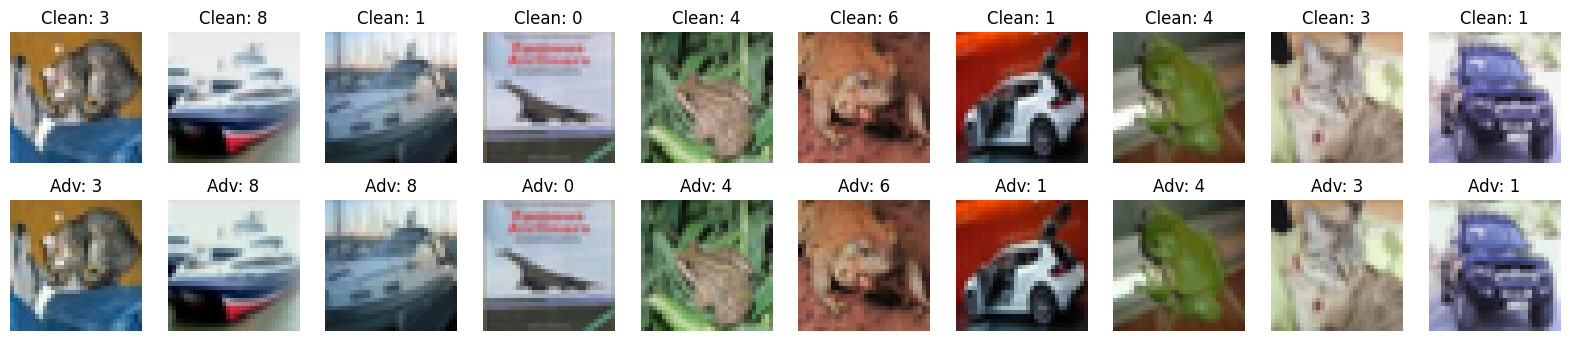

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8000 - loss: 0.6597
Accuracy on adversarial images: 0.80


In [1]:
# Step 1: Install necessary libraries
!pip install tensorflow matplotlib numpy

# Step 2: Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

# Step 3: Load CIFAR-10 dataset (as a proxy for satellite images)
# CIFAR-10 has classes like airplane, car, bird, etc. We use it as a surrogate for simplicity
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Preprocess the data: normalize images to [0, 1] and select only a subset of classes
train_images, test_images = train_images / 255.0, test_images / 255.0

# Step 4: Build a simple CNN model for image classification
def create_classifier():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Compile and train the classifier
classifier = create_classifier()
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

# Step 5: Evaluate the model on clean test images
_, accuracy = classifier.evaluate(test_images, test_labels)
print(f'Accuracy on clean test set: {accuracy:.2f}')

# Step 6: Define a GAN model for generating adversarial examples
def create_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(32, 32, 3))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = models.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

# Generator to create slight modifications in input images
def create_generator():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
        layers.LeakyReLU(),
        layers.Conv2D(3, (3, 3), padding='same', activation='tanh')
    ])
    return model

# Discriminator to evaluate whether an image is real or modified
def create_discriminator():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate and compile GAN components
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)

# Step 7: Generate adversarial images using the GAN generator
def generate_adversarial_images(generator, images, epsilon=0.1):
    perturbations = generator.predict(images)
    adversarial_images = images + epsilon * perturbations
    adversarial_images = np.clip(adversarial_images, 0, 1)  # Clip to keep pixel values in [0, 1]
    return adversarial_images

# Generate a batch of adversarial images from the test set
adversarial_images = generate_adversarial_images(generator, test_images[:10])

# Step 8: Evaluate the classifier on adversarial images
pred_labels_clean = classifier.predict(test_images[:10]).argmax(axis=1)
pred_labels_adversarial = classifier.predict(adversarial_images).argmax(axis=1)

# Step 9: Compare predictions and visualize the impact of adversarial attack
print("Predictions on clean images:", pred_labels_clean)
print("Predictions on adversarial images:", pred_labels_adversarial)

# Visualize clean and adversarial images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axs[0, i].imshow(test_images[i])
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Clean: {pred_labels_clean[i]}')

    axs[1, i].imshow(adversarial_images[i])
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Adv: {pred_labels_adversarial[i]}')

plt.show()

# Step 10: Analysis
# Evaluate the accuracy on adversarial examples to determine impact
_, adv_accuracy = classifier.evaluate(adversarial_images, test_labels[:10])
print(f'Accuracy on adversarial images: {adv_accuracy:.2f}')
